# grn sub network

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42

import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

import scanpy as sc
import anndata as ad


from scipy.cluster import hierarchy
from scipy.spatial import distance
from collections import defaultdict

In [3]:
grnboost = pd.read_table("../../data/grn/gene_energy_sugar_grnboost2_addtype.csv", sep="\t")
adata = ad.read_h5ad("../../data/CC_DD_Exp_energy_sugar.h5ad")

In [107]:
def makeID(series):
    ids = sorted([series["gene"], series["variable"]])
    return ids[0]+"__"+ids[1]

def generate_corr(subgrn, Adata):
    #Acetyl_CoA_grn = grnboost .query('(TF=="Acetyl-CoA" or target=="Acetyl-CoA") and importance>=35')
    print(subgrn.shape)
    subgrn_corr = Adata.to_df().loc[:, list(set(pd.concat([subgrn["TF"], subgrn["target"]], axis=0)))].corr()
    subgrn_corr["gene"] = subgrn_corr.index
    subgrn_corr = subgrn_corr.melt(id_vars=["gene"])
    subgrn_corr = subgrn_corr.query('gene != variable')
    subgrn_corr["id"] = subgrn_corr.apply(makeID, axis=1)
    subgrn_corr = subgrn_corr.drop_duplicates(["id"])
    del subgrn_corr['id']
    subgrn_corr['absCorr'] = abs(subgrn_corr['value'])
    #subgrn_corr = subgrn_corr.query('absCorr>=0.9')
    subgrn_corr.columns = ["TF", "target", "importance", "absCorr"]
    #subgrn_corr.shape
    return subgrn_corr

Suc_grn = grnboost.query('(TF=="Suc" or target=="Suc") and importance>=35')
Suc_grn_corr = generate_corr(Suc_grn, adata)


(791, 6)


<ipython-input-107-983520cf4f1f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgrn_corr["id"] = subgrn_corr.apply(makeID, axis=1)


In [148]:
targets

['Solyc11g011330.2',
 'Solyc07g014730.3',
 'Solyc02g076730.3',
 'Solyc02g076750.3',
 'Solyc02g088690.4',
 'Suc']

In [176]:
Suc_high_corr_targets = Suc_grn_corr.query('TF == "Suc"').query('absCorr>=0.75')
print(Suc_high_corr_targets.shape)
targets = Suc_high_corr_targets["target"].to_list()
targets.append('Suc')
target_tf = Suc_grn_corr[(Suc_grn_corr["TF"].isin(targets)==True) & (Suc_grn_corr["target"].isin(targets)==True)].query('absCorr>0.5')
print(target_tf.shape)
suc_tar_tf = pd.concat([Suc_target, target_tf], axis=0)

suc_tar_tf['TF_type'] = adata.var.loc[suc_tar_tf['TF'],"type"].to_list()
suc_tar_tf['target_type'] = adata.var.loc[suc_tar_tf['target'],"type"].to_list()

(24, 4)
(299, 4)


In [177]:
suc_tar_tf['TF_type'].unique()

array(['sugar', 'gene'], dtype=object)

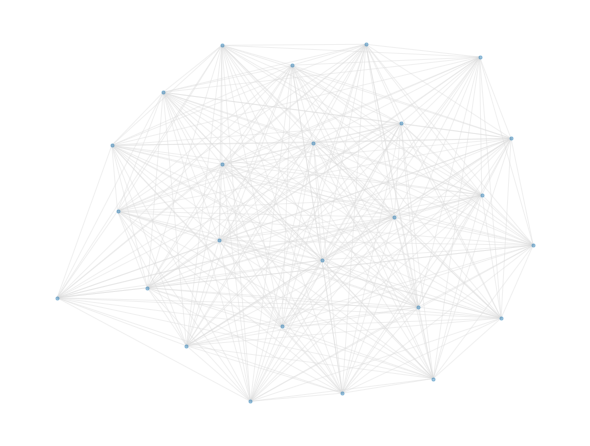

In [178]:
def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = np.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    # Create hierarchical cluster
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership = list(hierarchy.fcluster(Z, t=1.15))
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())


def subG(df):
    G = nx.Graph()
    G.clear()
    nodes = list(set(pd.concat([df["TF"], df["target"]], axis=0)))
    subG = nx.Graph()
    
    for i in nodes:
        G.add_node(i)
    for i,row in df.iterrows():
        G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])
    return G

def network_G_pos(grn_sub, Adata):
    G = nx.Graph()
    G.clear()

    U = nx.Graph()
    U.clear()
    
    nodes = list(set(pd.concat([grn_sub["TF"], grn_sub["target"]], axis=0)))
    nodes_df = Adata.var.loc[nodes,:]
    nodes_df['range'] = range(nodes_df.shape[0])

    for i in nodes_df.index:
        G.add_node(i)

    for i, row in grn_sub.iterrows():
        G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])


    for i in grn_sub["TF"].unique():
        subdf = grn_sub[grn_sub["TF"]==i]
        sG = subG(subdf)
        U = nx.disjoint_union(U, sG)
        #break

    #### draw graph ####
    plt.figure(1, figsize=(8, 6))
    # layout graphs with positions using graphviz neato

    H = G.subgraph(next(nx.connected_components(G)))
    # Makes life easier to have consecutively labeled integer nodes
    H = nx.convert_node_labels_to_integers(H)
    # Create parititions with hierarchical clustering
    partitions = create_hc(H)
    # Build blockmodel graph
    BM = nx.quotient_graph(H, partitions, relabel=True)

    # Draw original graph
    pos = nx.spring_layout(H, iterations=100, seed=42)  # Seed for reproducibility
    

    nx.draw(H, pos, with_labels=False, node_size=10, edge_color="gainsboro", alpha=0.4)
    return nodes_df, U, G, H, pos
    
    
nodes_df, U, G, H, pos = network_G_pos(suc_tar_tf, adata)


In [ ]:

pos = nx.nx_agraph.graphviz_layout(U, prog="neato")

plt.figure(1, figsize=(10, 8))

def plot_target_node(GG, poss, nodeDF, nodetype="gene", nodecolor="#2E7EB7", node_size=20, alpha=0.4):
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['range'].to_list()
    nodes_s = nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_size=node_size, node_color=nodecolor, alpha=alpha)
    
nodes1 = plot_target_node(H, pos, nodes_df[nodes_df.index.isin(grn_DF['TF'])==False], nodetype="gene", nodecolor="#2E7EB7", node_size=10)
nodes2 = plot_target_node(H, pos, nodes_df[nodes_df.index.isin(grn_DF['TF'])==False], nodetype="sugar", nodecolor="#581642", node_size=10)
nodes3 = plot_target_node(H, pos, nodes_df, nodetype="energy", nodecolor="#DBB53E", node_size=10)
nodes4 = plot_target_node(H, pos, nodes_df, nodetype="TF", nodecolor="#ED3833", node_size=10)
nodes5 = plot_target_node(H, pos, nodes_df, nodetype="TR", nodecolor="#ED3833", node_size=10)
    
    
def plot_TF_node(GG, poss, grn_DF, nodeDF, nodetype="sugar", nodecolor="red", node_size=20, alpha=0.4):
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['range'].to_list()
    
    target_count = pd.DataFrame(grn_DF.groupby(["TF"]).sum()['cc'])
    aa = nodeDF.index.isin(target_count.index)==False
    notIntarget_count = nodeDF.index[aa].to_list()
    
    notIntarget_count = pd.DataFrame({'cc':[1]*len(notIntarget_count)}, index=notIntarget_count)
    target_count = target_count.append(notIntarget_count)
    
    #target_count.loc[notIntarget_count, 'cc'] = [1]
    #print(target_count)
    
    node_size = node_size * target_count.loc[nodeDF.index, 'cc']/6
    nodes_s = nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_size=node_size, 
                                     node_color=nodecolor, 
                                     #label=nodeDF.index.to_list(), 
                                     alpha=alpha)
    
nodes6 = plot_TF_node(H, pos, grnboost_sub, nodes_df, nodetype="sugar", nodecolor="#581642", node_size=20)
nodes7 = plot_TF_node(H, pos, grnboost_sub, nodes_df, nodetype="energy", nodecolor="#DBB53E", node_size=20)

top7TFs = grnboost_sub[['TF', 'targetN']].sort_values(['targetN'], ascending=False).drop_duplicates().head(10)['TF'].to_list()
top7TFs = nodes_df.loc[top7TFs,:]

bbox={'facecolor': 'w', #填充色
      'edgecolor': 'None',#外框色
      'alpha': 0.5, #框透明度
      'pad': 2,#本文与框周围距离
     }

nx.draw_networkx_labels(H, pos, labels={row['range']:i for i,row in top7TFs.iterrows()}, 
                        font_size=10, 
                        font_family="sans-serif", 
                        font_color='k',
                        bbox=bbox
                        )




edge_colors = grnboost_sub['importance'].to_list()
cmap = plt.cm.plasma

edges = nx.draw_networkx_edges(H, pos, edge_color="gainsboro", alpha=0.4)

ax = plt.gca()
ax.scatter(None,None, label='sugar', color='#581642')
ax.scatter(None,None, label='energy', color='#DBB53E')
ax.scatter(None,None, label='gene', color='#2E7EB7')
ax.scatter(None,None, label='TF/TR', color='#ED3833')
ax.legend(loc=5)
ax.margins(0.15)
plt.axis("off")
plt.tight_layout()


#ax.set_axis_off()
#plt.show()
#plt.savefig("tomato_t_network.pdf")


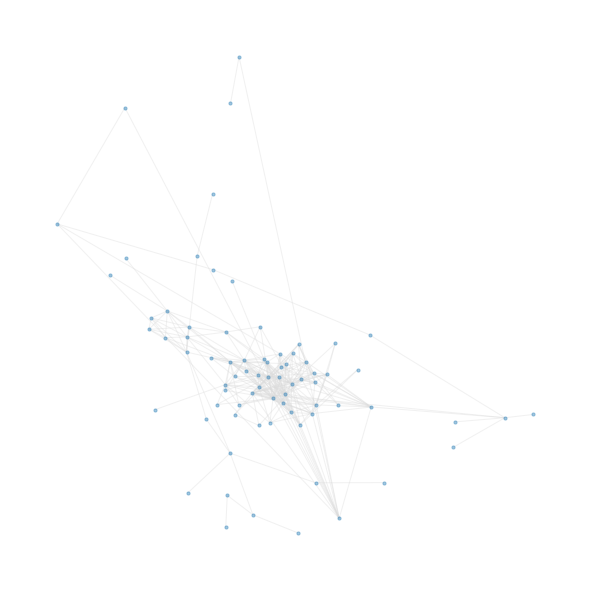

In [101]:
def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = np.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    # Create hierarchical cluster
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership = list(hierarchy.fcluster(Z, t=1.15))
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())


def subG(df):
    G = nx.Graph()
    G.clear()
    nodes = list(set(pd.concat([df["TF"], df["target"]], axis=0)))
    subG = nx.Graph()
    
    for i in nodes:
        G.add_node(i)
    for i,row in df.iterrows():
        G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])
    return G

def network_G_pos(grn_sub, Adata):
    G = nx.Graph()
    G.clear()

    U = nx.Graph()
    U.clear()
    
    nodes = list(set(pd.concat([grn_sub["TF"], grn_sub["target"]], axis=0)))
    nodes_df = Adata.var.loc[nodes,:]
    nodes_df['range'] = range(nodes_df.shape[0])

    for i in nodes_df.index:
        G.add_node(i)

    for i, row in grn_sub.iterrows():
        G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])


    for i in grn_sub["TF"].unique():
        subdf = grn_sub[grn_sub["TF"]==i]
        sG = subG(subdf)
        U = nx.disjoint_union(U, sG)
        #break

    #### draw graph ####
    plt.figure(1, figsize=(8, 8))
    # layout graphs with positions using graphviz neato

    H = G.subgraph(next(nx.connected_components(G)))
    # Makes life easier to have consecutively labeled integer nodes
    H = nx.convert_node_labels_to_integers(H)
    # Create parititions with hierarchical clustering
    partitions = create_hc(H)
    # Build blockmodel graph
    BM = nx.quotient_graph(H, partitions, relabel=True)

    # Draw original graph
    pos = nx.spring_layout(H, iterations=20, seed=83)  # Seed for reproducibility
    

    nx.draw(H, pos, with_labels=False, node_size=10, edge_color="gainsboro", alpha=0.4)
    return U, G, H, pos
    
    
U, G, H, pos = network_G_pos(Acetyl_CoA_grn_corr, adata)


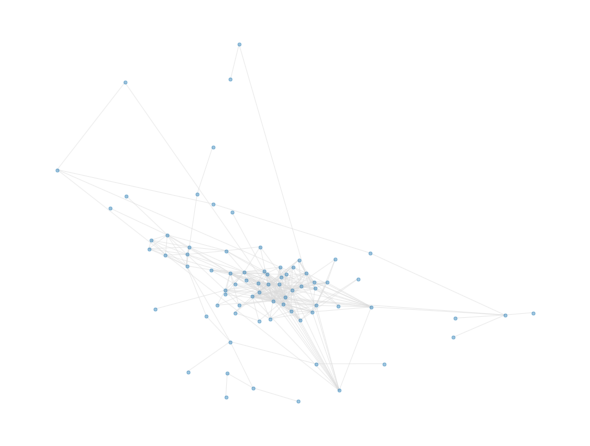

In [105]:
def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = np.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    # Create hierarchical cluster
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership = list(hierarchy.fcluster(Z, t=1.15))
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())


def subG(df):
    G = nx.Graph()
    G.clear()
    nodes = list(set(pd.concat([df["TF"], df["target"]], axis=0)))
    subG = nx.Graph()
    
    for i in nodes:
        G.add_node(i)
    for i,row in df.iterrows():
        G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])
    return G

def network_G_pos(grn_sub, Adata):
    G = nx.Graph()
    G.clear()

    nodes = list(set(pd.concat([grn_sub["TF"], grn_sub["target"]], axis=0)))
    nodes_df = Adata.var.loc[nodes,:]
    nodes_df['range'] = range(nodes_df.shape[0])

    for i in nodes_df.index:
        G.add_node(i)

    for i, row in grn_sub.iterrows():
        G.add_edge(row['TF'], row['target'], length=row['importance'], weight=row['importance'])

    #### draw graph ####
    plt.figure(1, figsize=(8, 6))
    # layout graphs with positions using graphviz neato

    H = G.subgraph(next(nx.connected_components(G)))
    # Makes life easier to have consecutively labeled integer nodes
    H = nx.convert_node_labels_to_integers(H)
    # Create parititions with hierarchical clustering
    partitions = create_hc(H)
    # Build blockmodel graph
    BM = nx.quotient_graph(H, partitions, relabel=True)

    # Draw original graph
    pos = nx.spring_layout(H, iterations=20, seed=83)  # Seed for reproducibility
    

    nx.draw(H, pos, with_labels=False, node_size=10, edge_color="gainsboro", alpha=0.4)
    return nodes_df, G, H, pos
    
    
nodes_df, G, H, pos = network_G_pos(Acetyl_CoA_grn_corr, adata)


In [106]:

pos = nx.nx_agraph.graphviz_layout(U, prog="neato")

plt.figure(1, figsize=(10, 8))

def plot_target_node(GG, poss, nodeDF, nodetype="gene", nodecolor="#2E7EB7", node_size=20, alpha=0.4):
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['range'].to_list()
    nodes_s = nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_size=node_size, node_color=nodecolor, alpha=alpha)
    
nodes1 = plot_target_node(H, pos, nodes_df[nodes_df.index.isin(grn_DF['TF'])==False], nodetype="gene", nodecolor="#2E7EB7", node_size=10)
nodes2 = plot_target_node(H, pos, nodes_df[nodes_df.index.isin(grn_DF['TF'])==False], nodetype="sugar", nodecolor="#581642", node_size=10)
nodes3 = plot_target_node(H, pos, nodes_df, nodetype="energy", nodecolor="#DBB53E", node_size=10)
nodes4 = plot_target_node(H, pos, nodes_df, nodetype="TF", nodecolor="#ED3833", node_size=10)
nodes5 = plot_target_node(H, pos, nodes_df, nodetype="TR", nodecolor="#ED3833", node_size=10)
    
    
def plot_TF_node(GG, poss, grn_DF, nodeDF, nodetype="sugar", nodecolor="red", node_size=20, alpha=0.4):
    nodeDF = nodeDF[nodeDF["type"]==nodetype]
    nodelist = nodeDF['range'].to_list()
    
    target_count = pd.DataFrame(grn_DF.groupby(["TF"]).sum()['cc'])
    aa = nodeDF.index.isin(target_count.index)==False
    notIntarget_count = nodeDF.index[aa].to_list()
    
    notIntarget_count = pd.DataFrame({'cc':[1]*len(notIntarget_count)}, index=notIntarget_count)
    target_count = target_count.append(notIntarget_count)
    
    #target_count.loc[notIntarget_count, 'cc'] = [1]
    #print(target_count)
    
    node_size = node_size * target_count.loc[nodeDF.index, 'cc']/6
    nodes_s = nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_size=node_size, 
                                     node_color=nodecolor, 
                                     #label=nodeDF.index.to_list(), 
                                     alpha=alpha)
    
nodes6 = plot_TF_node(H, pos, grnboost_sub, nodes_df, nodetype="sugar", nodecolor="#581642", node_size=20)
nodes7 = plot_TF_node(H, pos, grnboost_sub, nodes_df, nodetype="energy", nodecolor="#DBB53E", node_size=20)

top7TFs = grnboost_sub[['TF', 'targetN']].sort_values(['targetN'], ascending=False).drop_duplicates().head(10)['TF'].to_list()
top7TFs = nodes_df.loc[top7TFs,:]

bbox={'facecolor': 'w', #填充色
      'edgecolor': 'None',#外框色
      'alpha': 0.5, #框透明度
      'pad': 2,#本文与框周围距离
     }

nx.draw_networkx_labels(H, pos, labels={row['range']:i for i,row in top7TFs.iterrows()}, 
                        font_size=10, 
                        font_family="sans-serif", 
                        font_color='k',
                        bbox=bbox
                        )




edge_colors = grnboost_sub['importance'].to_list()
cmap = plt.cm.plasma

edges = nx.draw_networkx_edges(H, pos, edge_color="gainsboro", alpha=0.4)

ax = plt.gca()
ax.scatter(None,None, label='sugar', color='#581642')
ax.scatter(None,None, label='energy', color='#DBB53E')
ax.scatter(None,None, label='gene', color='#2E7EB7')
ax.scatter(None,None, label='TF/TR', color='#ED3833')
ax.legend(loc=5)
ax.margins(0.15)
plt.axis("off")
plt.tight_layout()


#ax.set_axis_off()
#plt.show()
#plt.savefig("tomato_t_network.pdf")


ImportError: requires pygraphviz http://pygraphviz.github.io/